# Tackling **Cats vs Dogs ** kaggle challenge using **transfer-learning** and pytorch

 

## Introduction

 

![Cats vs Dogs](https://kaggle2.blob.core.windows.net/competitions/kaggle/3362/media/woof_meow.jpg)

 

[The challenge](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition) provides a dataset of

 

-  12,500 Cat photos

-  12,500 Dog photos

 

and then asks us to predict the category of 12,500 test images (Cat or Dog). The submission is evaluated based on log loss (smaller is better):

$$ \textrm{LogLoss} = - \frac{1}{n} \sum_{i=1}^n \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)\right],$$

 

## Approach

 

As shown in the figure below, my approach will be as follows:

![Approach](./figures/Transfer_Learning.png) 

1.  Use a pretrained imagenet model (e.g. resnet-152)

2.  Replace the last fully-connected layer with a new one with binary output, while freezing the rest of the layers and train on the given image dataset.

3.  Unfreeze a few preceding layers and retrain for further fine-tuning.

 

As in some other projects, I'll use [ **Pytorch** ](pytorch.org), which I am increasingly a fan of.

 

 

## Implementation

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import os

plt.ion()

In [7]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = '.'
dsets = { x : datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x])
            for x in ['train', 'validation', 'test']}
dset_loaders = { x : torch.utils.data.DataLoader(dsets[x], batch_size=16, shuffle=True, num_workers=4)
                   for x in ['train', 'validation', 'test']}
dset_sizes = { x : len(dsets[x]) for x in ['train', 'validation', 'test']}
dset_classes = dsets['train'].classes

use_gpu = torch.cuda.is_available()

In [8]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose([1, 2, 0])
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = inp * std + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()



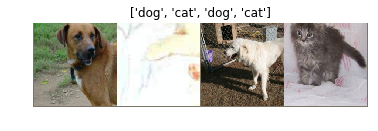

In [9]:
inputs, classes = next(iter(dset_loaders['train']))

out = torchvision.utils.make_grid(inputs[:4])

imshow(out, title= [dset_classes[x] for x in classes[:4]])

In [10]:
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=25):
    
    since = time.time()
    
    best_model = model
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('--------------')
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)
            else:
                model.train(False)
            
            running_loss = 0.0
            running_corrects = 0
            
            for data in dset_loaders[phase]:
                
                inputs, labels = data
                
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = variable(inputs), Variable(labels)
                
                optimizer.zero_grad()
                
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds.data == labels.data)
                
            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc  = running_corrects / dset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)
                
        print()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return best_model
                

In [11]:
def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

In [12]:
def visualize_model(model, num_images=4):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dset_loaders['validation']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(dset_classes[labels.data[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

In [15]:
model_conv = models.resnet34(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv.cuda()
    
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/sangeet/.torch/models/resnet34-333f7ec4.pth
100.0%


In [16]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
--------------
LR is set to 0.001
train Loss: 0.0118 Acc: 0.9166
validation Loss: 0.0033 Acc: 0.9825

Epoch 1/24
--------------
train Loss: 0.0103 Acc: 0.9303
validation Loss: 0.0025 Acc: 0.9875

Epoch 2/24
--------------
train Loss: 0.0105 Acc: 0.9301
validation Loss: 0.0023 Acc: 0.9885

Epoch 3/24
--------------
train Loss: 0.0106 Acc: 0.9283
validation Loss: 0.0026 Acc: 0.9865

Epoch 4/24
--------------
train Loss: 0.0102 Acc: 0.9317
validation Loss: 0.0024 Acc: 0.9885

Epoch 5/24
--------------
train Loss: 0.0104 Acc: 0.9292
validation Loss: 0.0025 Acc: 0.9885

Epoch 6/24
--------------
train Loss: 0.0101 Acc: 0.9310
validation Loss: 0.0023 Acc: 0.9885

Epoch 7/24
--------------
LR is set to 0.0001
train Loss: 0.0093 Acc: 0.9376
validation Loss: 0.0023 Acc: 0.9885

Epoch 8/24
--------------
train Loss: 0.0093 Acc: 0.9350
validation Loss: 0.0023 Acc: 0.9895

Epoch 9/24
--------------
train Loss: 0.0096 Acc: 0.9339
validation Loss: 0.0024 Acc: 0.9875

Epoch 10/24
---------

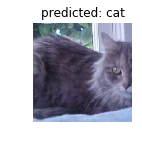

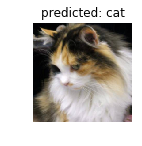

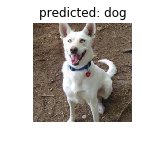

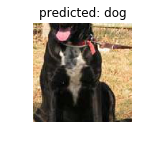

In [17]:
visualize_model(model_conv)
plt.ioff()
plt.show()

In [18]:
torch.save(model_conv.state_dict(), './model1.pth')

In [19]:
for parameter in list(model_conv.parameters())[:6]:
    parameter.requires_grad = False
    
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
--------------
LR is set to 0.001
train Loss: 0.0097 Acc: 0.9362
validation Loss: 0.0023 Acc: 0.9865

Epoch 1/24
--------------
train Loss: 0.0096 Acc: 0.9350
validation Loss: 0.0023 Acc: 0.9890

Epoch 2/24
--------------
train Loss: 0.0098 Acc: 0.9321
validation Loss: 0.0024 Acc: 0.9875

Epoch 3/24
--------------
train Loss: 0.0099 Acc: 0.9340
validation Loss: 0.0023 Acc: 0.9900

Epoch 4/24
--------------
train Loss: 0.0098 Acc: 0.9331
validation Loss: 0.0027 Acc: 0.9860

Epoch 5/24
--------------
train Loss: 0.0100 Acc: 0.9337
validation Loss: 0.0023 Acc: 0.9890

Epoch 6/24
--------------
train Loss: 0.0096 Acc: 0.9363
validation Loss: 0.0023 Acc: 0.9905

Epoch 7/24
--------------
LR is set to 0.0001
train Loss: 0.0096 Acc: 0.9369
validation Loss: 0.0027 Acc: 0.9870

Epoch 8/24
--------------
train Loss: 0.0098 Acc: 0.9339
validation Loss: 0.0026 Acc: 0.9865

Epoch 9/24
--------------
train Loss: 0.0100 Acc: 0.9337
validation Loss: 0.0027 Acc: 0.9845

Epoch 10/24
---------

In [20]:
torch.save(model_conv.state_dict(), './model2.pth')